In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

C:\Development\WebstormProjects\trash-bandicoot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
# 1. Parameters & data generation (as before)
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=838, freq="D")
products = ["P01", "P02", "P03"]
records = []
for pid in products:
    base = np.random.uniform(20, 50)
    weekly = 10 * np.sin(2 * np.pi * dates.dayofweek / 7)
    noise = np.random.normal(0, 5, size=len(dates))
    sales = np.maximum(0, base + weekly + noise).round().astype(int)
    df = pd.DataFrame({"date": dates, "product_id": pid, "sales": sales})
    records.append(df)
sales_data = pd.concat(records, ignore_index=True)
sales_data.to_csv("sales_data.csv", index=False)

In [11]:
# 2. Load & prepare for Prophet
sales = pd.read_csv("sales_data.csv", parse_dates=["date"])
sales = sales.rename(columns={"date": "ds", "sales": "y"})

In [12]:
# 3. Forecast per product
forecast_horizon = 30
all_forecasts = []
for pid, group in sales.groupby("product_id"):
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.fit(group[["ds", "y"]])
    future = m.make_future_dataframe(periods=forecast_horizon)
    fcst = m.predict(future)[["ds", "yhat"]]
    fcst["product_id"] = pid
    all_forecasts.append(fcst)
forecast_df = pd.concat(all_forecasts)

20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# 4. Combine actuals & forecasts
hist = sales.rename(columns={"y": "value"})[["ds", "product_id", "value"]]
hist["type"] = "Actual"
fcast = forecast_df.rename(columns={"yhat": "value"})[["ds", "product_id", "value"]]
fcast["type"] = "Forecast"
df_plot = pd.concat([hist, fcast], ignore_index=True)


In [14]:
# 5. Seaborn style
sns.set_style("whitegrid")

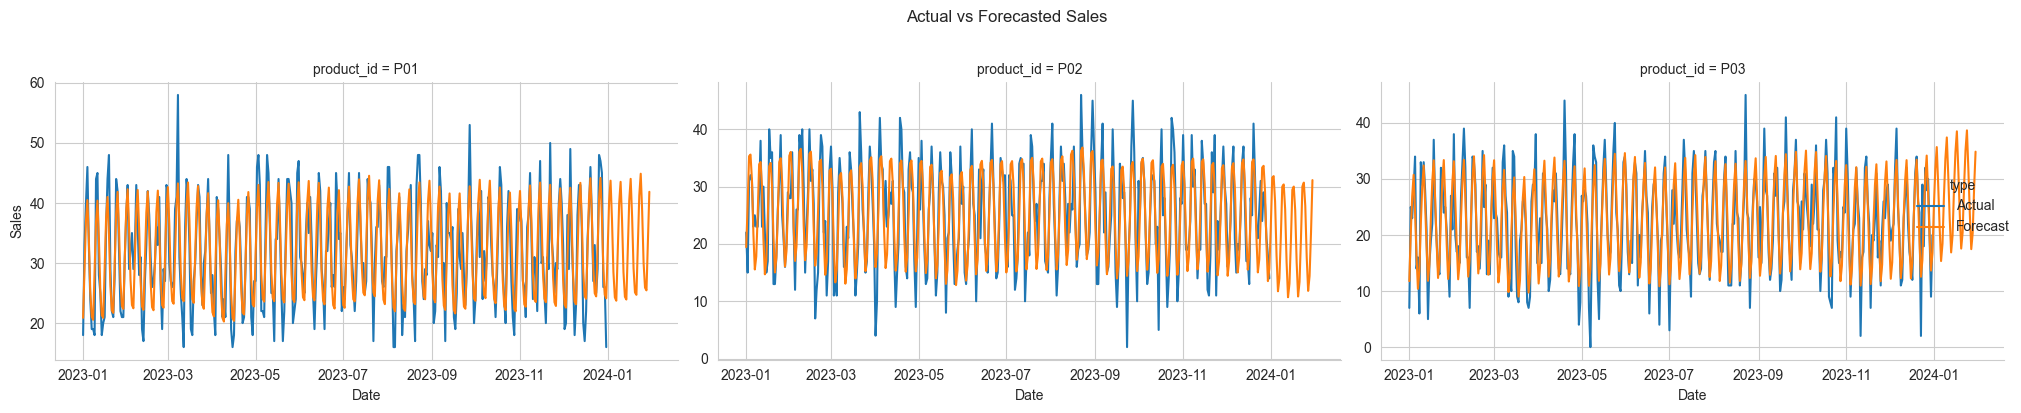

In [15]:
# 6. Time‑series: Actual vs Forecast
g = sns.FacetGrid(df_plot, col="product_id", hue="type",
                  height=4, aspect=1.6, sharey=False)
g.map(sns.lineplot, "ds", "value").add_legend()
g.set_axis_labels("Date", "Sales")
g.fig.suptitle("Actual vs Forecasted Sales", y=1.02)
plt.tight_layout()
plt.show()

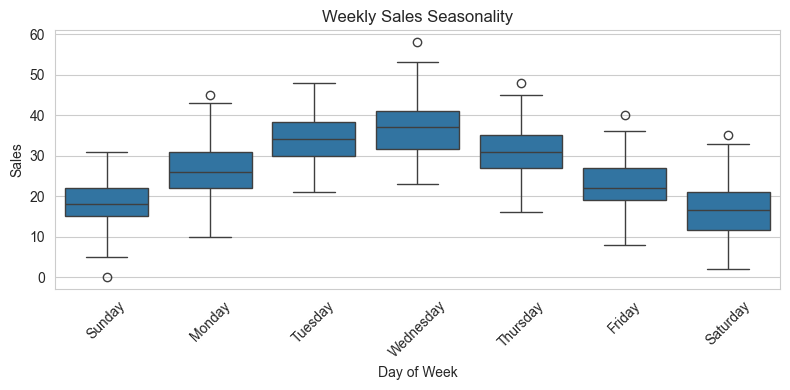

In [16]:
# 7. Weekly seasonality boxplot
sales["dow"] = sales["ds"].dt.day_name()
plt.figure(figsize=(8, 4))
sns.boxplot(data=sales, x="dow", y="y")
plt.title("Weekly Sales Seasonality")
plt.xticks(rotation=45)
plt.ylabel("Sales")
plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()

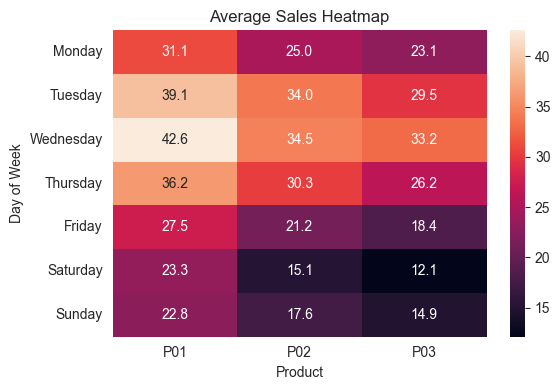

In [17]:
# 8. Heatmap: Avg. sales by day & product
pivot = sales.pivot_table(
    index="dow", columns="product_id", values="y", aggfunc="mean"
).reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".1f")
plt.title("Average Sales Heatmap")
plt.ylabel("Day of Week")
plt.xlabel("Product")
plt.tight_layout()
plt.show()